## Offline analysis

here we will explore

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
plt.style.use('science')

---
### Energy
Let us start this notebook by first analyzing the accuracy of our code. The gravitational problem is an example of an Hamiltonian system described by the Hamiltonian:
$$
H(\vec r, \vec v) = \frac{1}{2}\sum_i m_i v_i^2 + \frac{1}{2}\sum_{i\neq j} \frac{G m_i m_j}{r_{ij}}
$$
conserved (£H=const$) throughout the dynamical evolution of the closed system. Therefore, to assess the quality and stability of our numerical integrators, we can monitor the fluctuations of the computed empirical energy $E(t)$ over time. A stable integrator should maintain $E(t)$ nearly constant, with only bounded oscillations due to numerical precision.

We used two different integration schemes: **Velocity Verlet** (symplectic, stable) and **Euler** (first-order, unstable). For each integrator, we compared the total energy evolution $E(t)$ across three different hardware/software implementations:

1.  **Serial:** The baseline reference implementation. Code is executed on my CPU, single-thread
2.  **OpenMP:** Multi-threaded CPU execution. Code is executed in parallel thanks to OpenMP, still on the CPU
3.  **CUDA:** GPU execution

The specific parallelization paradigm (CPU, GPU ...) should not alter the *physics* of the solution, hence we should obtain similar results. However, to rigorously verify algorithmic correctness as a sanity check, these simulations were performed on all three implementations. Most importantly, we also analyized how switching from Double to Float may affect the energy conservation

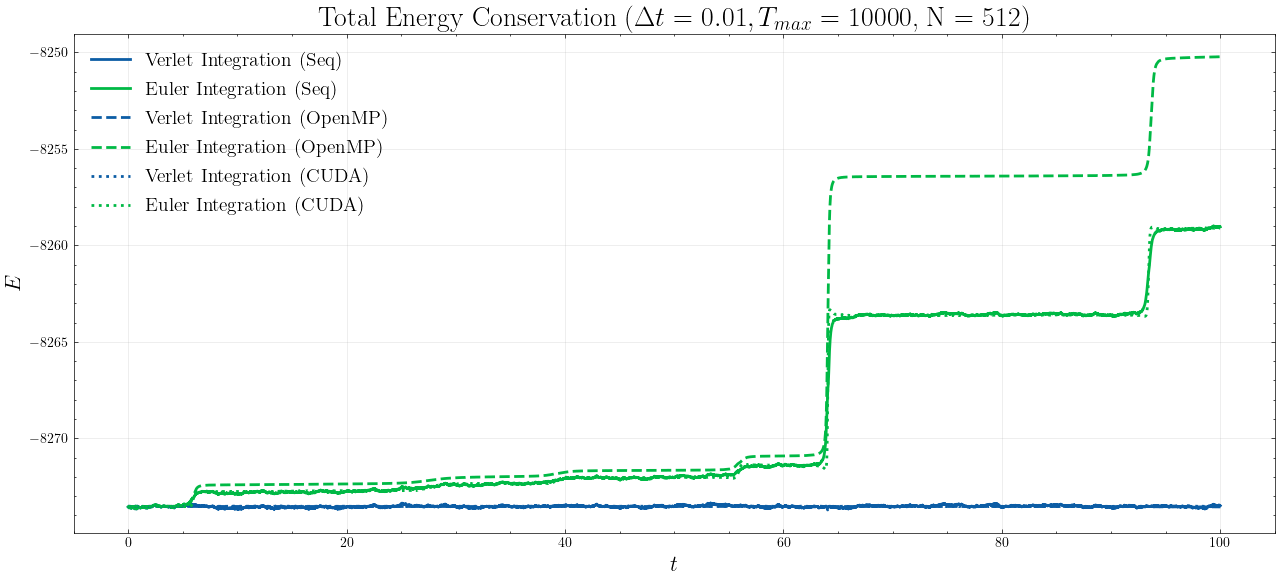

In [10]:
plt.figure(figsize=(13,6), dpi = 100)
prec = "Float"
# Sequential data
filenameVerlet = f"../data/CPUSequential/energyVerlet{prec}.dat"
filenameEuler = f"../data/CPUSequential/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, label='Verlet Integration (Seq)', lw = 2, color='C0')
plt.plot(time, energyEuler, label='Euler Integration (Seq)', lw = 2, color='C1')

# OpenMP, nthreads = 8 
filenameVerlet = f"../data/CPUParallel/energyVerlet{prec}.dat"
filenameEuler = f"../data/CPUParallel/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, '--', label='Verlet Integration (OpenMP)', lw = 2,color='C0')
plt.plot(time, energyEuler, '--', label='Euler Integration (OpenMP)', lw = 2, color='C1')

# CUDA, naive
filenameVerlet = f"../data/GPU/energyVerlet{prec}.dat"
filenameEuler = f"../data/GPU/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, ':', label='Verlet Integration (CUDA)', lw = 2,color='C0')
plt.plot(time, energyEuler, ':', label='Euler Integration (CUDA)', lw = 2, color='C1')


plt.title(r'Total Energy Conservation     ($\Delta t = 0.01, T_{max} = 10000$, N = 512)', fontsize=20)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$E$', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

As expected, Euler integration greatly violates energy conservation. This behavior is intrinsic to the algorithm: being a first-order method ($O(\Delta t)$), it introduces a systematic error at every time step. In orbital mechanics, this error manifests as a constant "energy drift," causing the system to gain non-physical energy: this is particularly evident for specific time where the energy abruptly increases. Those are points where bodies are colliding violently into each other and where the accuracy of Euler is at its lowest (causing injection of spurious energy into the system if $\Delta t$ is not small enough)

In contrast, the Velocity Verlet integrator demonstrates good stability. It preserves the geometric properties of the phase space and, while the energy is not conserved *exactly* (due to discrete time-stepping), it oscillates within a bounded interval rather than drifting linearly. This "bounded error" property makes Verlet suitable for long-term N-Body simulations.

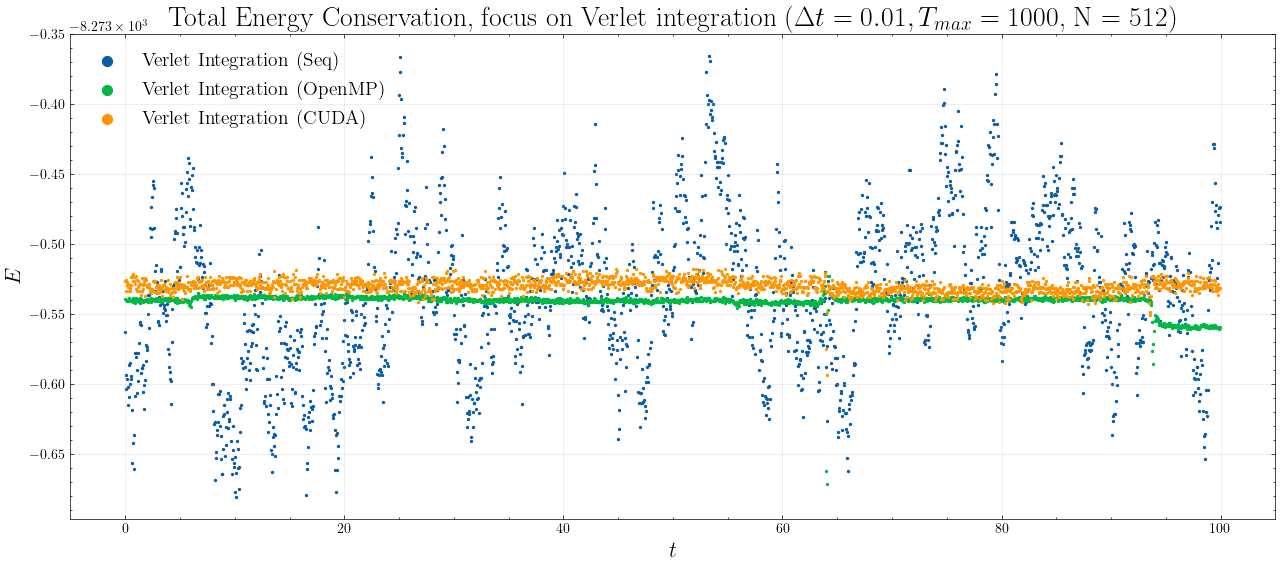

In [ ]:
plt.figure(figsize=(13,6), dpi = 100)
prec = "Float"
# Sequential data
filenameVerlet = f"../data/CPUSequential/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (Seq)', s = 2)

# OpenMP, nthreads = 8 (but useless)
filenameVerlet = f"../data/CPUParallel/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (OpenMP)', s = 2)

# CUDA, naive
filenameVerlet = f"../data/GPU/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (CUDA)', s = 2)

plt.title(r'Total Energy Conservation, focus on Verlet integration     ($\Delta t = 0.01, T_{max} = 10000$, N = 512)', fontsize=20)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$E$', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, markerscale=5) 
plt.tight_layout()
plt.show()

Now the perfomance analysis

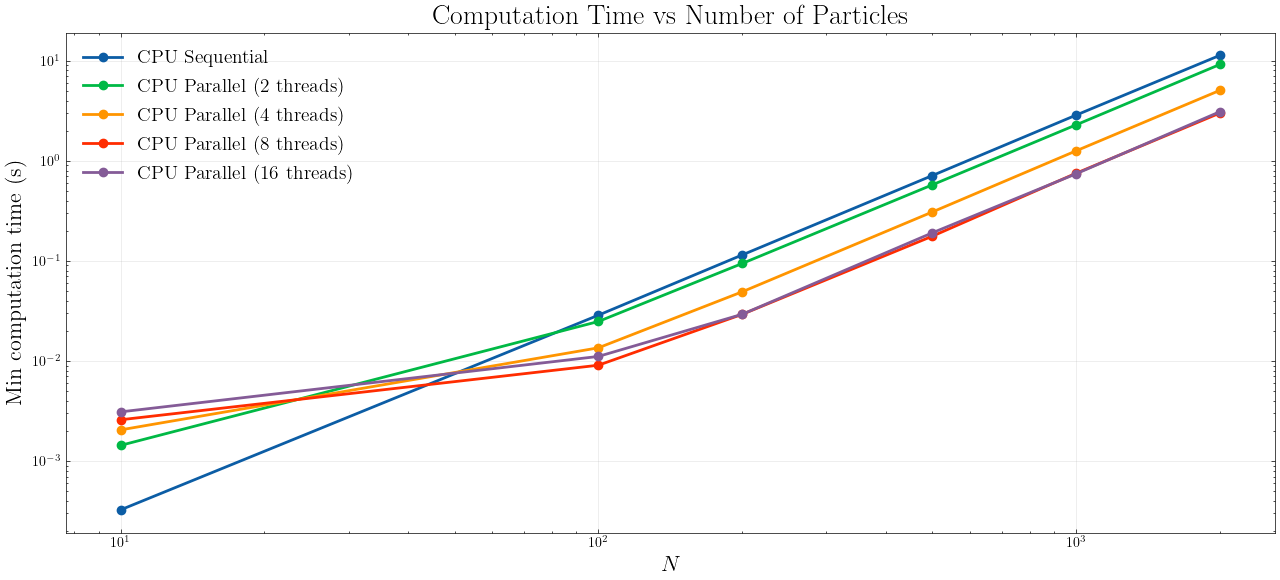

In [22]:
plt.figure(figsize=(13,6), dpi = 100)
# CP sequential
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
times = []

lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    times.append(np.min(buffer))
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"

    nParticles = []
    times = []

    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        times.append(np.min(buffer))
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)

plt.xscale('log')
plt.yscale('log')
plt.title(r'Computation Time vs Number of Particles', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Min computation time (s)', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

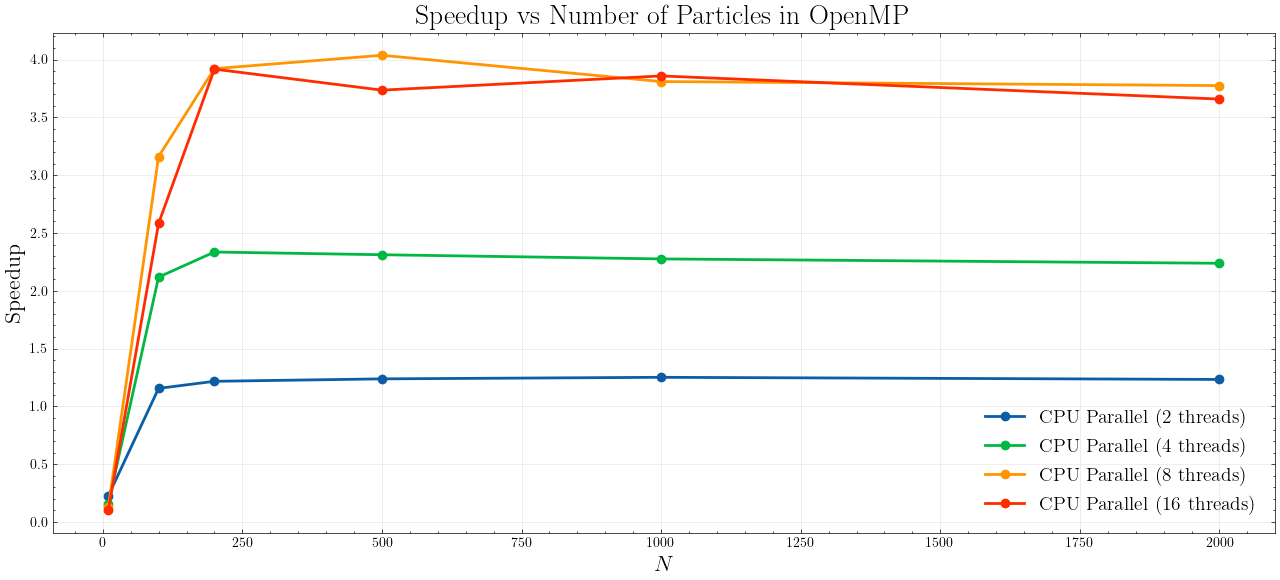

In [23]:
## Speedup in OpenMP
plt.figure(figsize=(13,6), dpi = 100)
# Sequential data
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
timesSeq = []
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    timesSeq.append(np.min(buffer))

timesPar = []
for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"
    nParticles = []
    timesPar = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        timesPar.append(np.min(buffer))
    speedup = np.array(timesSeq)/np.array(timesPar)
    plt.plot(nParticles, speedup, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)

plt.title(r'Speedup vs Number of Particles in OpenMP', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Speedup', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

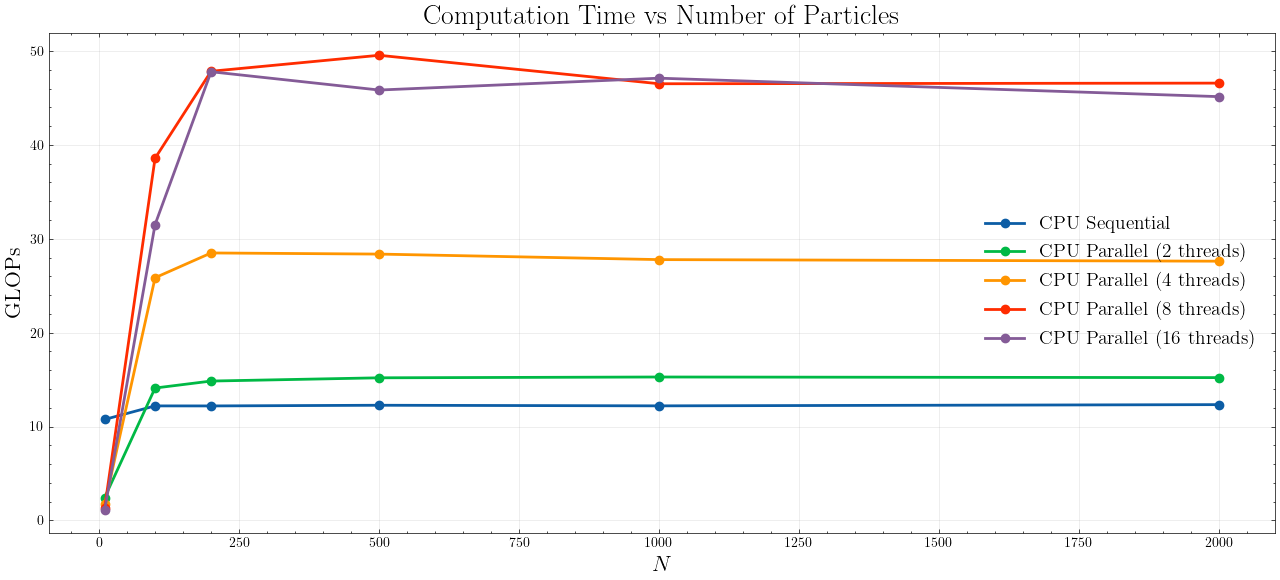

In [24]:
steps = 1000
ops_per_interaction = 35.0
REP = 15
threads = [2, 4, 8, 16]
plt.figure(figsize=(13,6), dpi = 100)



nParticles = []
times = []
filename = "../data/CPUSequential/timeVersusN.dat"
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
    times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"

    nParticles = []
    times = []

    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
        times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)

plt.title(r'Computation Time vs Number of Particles', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'GLOPs', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, loc='best')
plt.tight_layout()
plt.show()